# Exploratory data analaysis for world bank data

## Set export to True if you wish to export graphs and tables


In [1]:
save_figures = True

In [8]:
import warnings
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
import xgboost as xgb
from imblearn.over_sampling import ADASYN 
from sklearn.metrics import confusion_matrix, f1_score
warnings.simplefilter('ignore')
import geopandas as gpd
%matplotlib inline


In [3]:
df = pd.read_csv(
    '../datasets/world_bank_processed_ethiopia.csv', parse_dates=['date'])
set_index(df)
df_loc = df[['centx', 'centy']].droplevel(1).drop_duplicates()

In [4]:
def replicate_experiment(n, df_copy, seed=1337):
    
    # Interpolating FEWS IPC data at a monthly basis, 
    # and cutting of data beforethe start/end date
    # (no missing values in-between after this step)
    df = df_copy[['fews_ipc']].groupby('area').apply(lambda x: x.interpolate(method='linear')).copy()
    date_mask = df.index.get_level_values(1) >= pd.to_datetime('2010-01-01')
    date_mask = date_mask & (df.index.get_level_values(1) <= pd.to_datetime('2018-06-01'))
    df = df[date_mask]
    
    df['fews_ipc'] = df['fews_ipc'].round()
    for lag in range(n, n+6):
        lagged = df.groupby('area').apply(lambda x: x['fews_ipc'].shift(lag)).droplevel(0).rename(f'fews_ipc_l{lag}')
        df = pd.concat([df, lagged], axis=1)
    
    # creating the variable change event
    df['CE'] = -((df['fews_ipc']) - (df[f'fews_ipc_l{n}']))
    df['CE'] = ((df['CE'] < 0) * -1 + (df['CE'] > 0) * 1).astype('int8')
    # the cumulative counts for how many change events have happend in the past
    det_count = df['CE'].groupby('area').apply(lambda x: (x == -1).cumsum().shift(n)).rename(f'det_count')
    net_count = df['CE'].groupby('area').apply(lambda x: (x == 0).cumsum().shift(n)).rename(f'neu_count')
    imp_count = df['CE'].groupby('area').apply(lambda x: (x == 1).cumsum().shift(n)).rename(f'imp_count')
    df = pd.concat([df, det_count, net_count, imp_count], axis=1)
    
    # dropping off all NA change events (NA due to lag)
    na_mask = df['CE'].isna()
    df = df[~na_mask]
    # we add one to all classifications to make them positive
    # (this does not change the classification objecitve)
    df['CE'] = df['CE'].astype('int8') + 1
    
    # the xgboost model, with all hyperparaters equal to the original study
    xgc = xgb.XGBClassifier(objective ='multi:softmax', use_label_encoder=False, max_depth=4, n_estimators=400, learning_rate=0.01, subsample=0.45, colsample_bytree=0.75, gamma=0.1, min_child_weight=7, reg_alpha=0.00001, reg_lambda=10, seed=seed)
    
    # creating X and y, for X we use the most recent 6 IPC lags from the lead up time 
    # as well as the counts (lagged). We oversample the training dataset using ADASYN
    X, y = df[[f'fews_ipc_l{i}' for i in range(n, n+6)] + ['det_count', 'neu_count', 'imp_count']], df['CE']
    na_mask = X.isna().any(axis=1)
    X, y= X[~na_mask], y[~na_mask]   

    split_mask = X.index.get_level_values(1) > pd.to_datetime('2016-01-31')

    X_train, y_train = X[~split_mask], y[~split_mask]
    X_test, y_test = X[split_mask], y[split_mask]

    ada = ADASYN(random_state=seed)
    X_res, y_res = ada.fit_resample(X_train, y_train)
    
    # fit the xgboost
    xgc.fit(X_res,y_res)
    # return the fitted model
    return X_test, y_test, xgc
    

In [320]:
M = 10 # number of runs
f1_scores = []
for n in range(1, 13):
    mean_f1 = np.zeros((M, 3))
    for i in range(M):
        X_test, y_test, xgc = replicate_experiment(n, df,  seed=i)
        y_pred = xgc.predict(X_test)
        mean_f1[i] = f1_score(y_test, y_pred, average=None)
    f1_scores.append(mean_f1.mean(axis=0))

f1_scores = pd.DataFrame(f1_scores)
f1_scores.columns = ['deterioration', 'no change', 'improvement']
f1_scores.index += 1

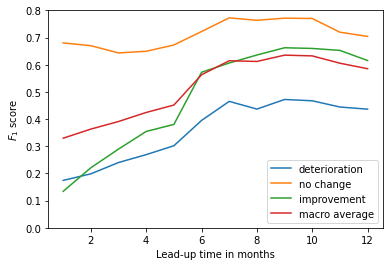

In [331]:
fig, ax = plt.subplots()
f1_scores['macro average'] = f1_scores.mean(axis=1)
f1_scores.plot(ax=ax)
ax.set_ylim(0, 0.8)
ax.set_xlabel('Lead-up time in months')
ax.set_ylabel(r'$F_{1}$ score');

if save_figures:
    fig.savefig('../figures/f1_score_reduced_ethiopia.pdf', type='pdf')

In [244]:
f1_scores

,deterioration,no change,improvement,macro average
1,0.174443,0.680296,0.134258,0.329666
2,0.198629,0.669939,0.221022,0.363197
3,0.240218,0.643332,0.289723,0.391091
4,0.269183,0.649502,0.354572,0.424419
5,0.301900,0.672697,0.380353,0.451650
6,0.395014,0.722077,0.572246,0.563112
7,0.465111,0.772419,0.606303,0.614611
8,0.436810,0.763413,0.635777,0.612000
9,0.472114,0.771286,0.662370,0.635257
10,0.467333,0.770093,0.659911,0.632445


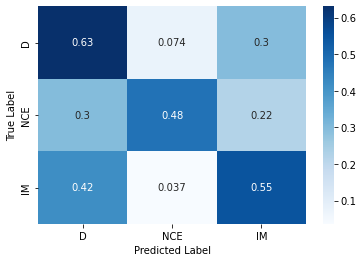

In [6]:
X_test, y_test, xgc = replicate_experiment(3, df, seed=1)
y_pred = xgc.predict(X_test)
f1_score(y_test, y_pred, average='macro')

fig, ax = plt.subplots()
C = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(C, annot=True, xticklabels=['D', 'NCE', 'IM'], yticklabels=['D', 'NCE', 'IM'], ax=ax, cmap='Blues')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');

if save_figures:
    fig.savefig('../figures/confusion_matrix_eth_reduced_3.pdf', type='pdf')

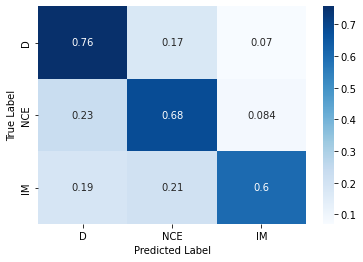

In [7]:
X_test, y_test, xgc = replicate_experiment(7, df, seed=1)
y_pred = xgc.predict(X_test)
f1_score(y_test, y_pred, average='macro')

fig, ax = plt.subplots()
C = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(C, annot=True, xticklabels=['D', 'NCE', 'IM'], yticklabels=['D', 'NCE', 'IM'], ax=ax, cmap='Blues')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');

if save_figures:
    fig.savefig('../figures/confusion_matrix_eth_reduced_7.pdf', type='pdf')

In [9]:
pred_df = pd.DataFrame(pd.Series(y_pred, index=y_test.index).rename('pred'))
pred_df['test'] = y_test


scores_by_area = []
for idx, df_g in pred_df.groupby('area'):
    scores_by_area.append([idx, f1_score(df_g['test'], df_g['pred'], average='macro')])
    
scores_by_area = pd.DataFrame(scores_by_area)
scores_by_area.columns = ['area', 'f1 (macro)']
scores_by_area.set_index('area', inplace=True)
scores_by_area = df_loc.merge(scores_by_area, left_index=True, right_on=['area'])

In [10]:
df_shape = gpd.read_file('../geography/Ethiopia/eth_admbnda_adm1_csa_bofedb_2021.shp')

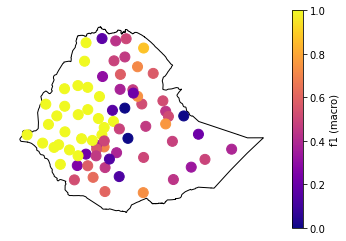

In [13]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[df_shape.geometry.unary_union]).plot(ax=ax, color='white', edgecolor='black')
scores_by_area.plot(x='centx', y='centy', c='f1 (macro)', kind='scatter', ax=ax, cmap='plasma', s=100)
plt.axis('off');

fig.savefig('../figures/eth_red_spatial.pdf', format='pdf')

In [289]:
date_mask = (df.index.get_level_values(1) > pd.to_datetime('2016-01-31')) & (df.index.get_level_values(1) <= pd.to_datetime('2018-06-01'))
scores_by_ipc = scores_by_area.merge(df[date_mask].groupby('area')['fews_ipc'].mean(), left_index=True, right_index=True)

In [296]:
scores_by_ipc.corr()

,centx,centy,f1 (macro),fews_ipc
centx,1.000000,0.018831,-0.565125,0.789527
centy,0.018831,1.000000,0.076501,-0.126878
f1 (macro),-0.565125,0.076501,1.000000,-0.520556
fews_ipc,0.789527,-0.126878,-0.520556,1.000000


In [293]:
scores_by_ipc[(scores_by_ipc['f1 (macro)'] == 1)]

,centx,centy,f1 (macro),fews_ipc
area,,,,
addis adaba,38.78548,8.980493,1.0,1.0
awi/agew,36.59705,11.189920,1.0,1.0
north gonder,37.00655,12.689380,1.0,1.0
kemashi,35.78286,9.914745,1.0,1.0
agnuak,34.42369,7.645877,1.0,1.0
majang,35.12831,7.381215,1.0,1.0
nuer,33.46947,8.154752,1.0,1.0
east wellega,36.61642,9.399154,1.0,1.0
horo guduru,37.20560,9.709824,1.0,1.0


In [294]:
scores_by_ipc[(scores_by_ipc['fews_ipc'] == 1)]

,centx,centy,f1 (macro),fews_ipc
area,,,,
addis adaba,38.78548,8.980493,1.0,1.0
awi/agew,36.59705,11.189920,1.0,1.0
north gonder,37.00655,12.689380,1.0,1.0
kemashi,35.78286,9.914745,1.0,1.0
agnuak,34.42369,7.645877,1.0,1.0
majang,35.12831,7.381215,1.0,1.0
nuer,33.46947,8.154752,1.0,1.0
east wellega,36.61642,9.399154,1.0,1.0
horo guduru,37.20560,9.709824,1.0,1.0


In [298]:
scores_by_ipc[(scores_by_ipc['fews_ipc'] != 1)].corr()

,centx,centy,f1 (macro),fews_ipc
centx,1.000000,0.040891,0.018489,0.625901
centy,0.040891,1.000000,0.055552,-0.149987
f1 (macro),0.018489,0.055552,1.000000,0.583503
fews_ipc,0.625901,-0.149987,0.583503,1.000000


In [314]:
phase1_districts = (scores_by_ipc[scores_by_ipc['fews_ipc'] == 1]).index
phase1_mask = get_area(df).isin(phase1_districts)

Text(0.5, 15.0, 'Predicted Label')

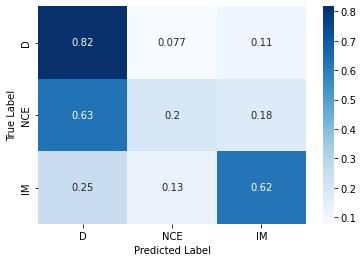

In [315]:
get_area(df).isin(phase1_districts)

X_test, y_test, xgc = replicate_experiment(7, df[~phase1_mask], seed=1)
y_pred = xgc.predict(X_test)
f1_score(y_test, y_pred, average='macro')

fig, ax = plt.subplots()
C = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(C, annot=True, xticklabels=['D', 'NCE', 'IM'], yticklabels=['D', 'NCE', 'IM'], ax=ax, cmap='Blues')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')